In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
# Load dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx"
df = pd.read_excel(url)

In [3]:
# Rename columns for better readability
df.columns = [
    "Relative Compactness", "Surface Area", "Wall Area", "Roof Area",
    "Overall Height", "Orientation", "Glazing Area", "Glazing Area Distribution",
    "Heating Load", "Cooling Load"
]

In [4]:
# Split into features (X) and targets (y)
X = df.iloc[:, :-2]  # First 8 columns
y = df.iloc[:, -2:]  # Last 2 columns (Heating Load & Cooling Load)

In [5]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
param_grid_gbr = {
    "estimator__learning_rate": [0.01, 0.1, 0.2],
    "estimator__n_estimators": [100, 200, 300],
    "estimator__max_depth": [3, 5, 7]
}

gbr = MultiOutputRegressor(GradientBoostingRegressor(random_state=42))
grid_gbr = GridSearchCV(gbr, param_grid_gbr, cv=5, scoring='r2', n_jobs=-1)
grid_gbr.fit(X_train_scaled, y_train)


GridSearchCV(cv=5,
             estimator=MultiOutputRegressor(estimator=GradientBoostingRegressor(random_state=42)),
             n_jobs=-1,
             param_grid={'estimator__learning_rate': [0.01, 0.1, 0.2],
                         'estimator__max_depth': [3, 5, 7],
                         'estimator__n_estimators': [100, 200, 300]},
             scoring='r2')

In [8]:
# Train the best Gradient Boosting model
best_gbr = grid_gbr.best_estimator_

In [9]:
# Hyperparameter tuning for MLP Regressor
param_grid_mlp = {
    "hidden_layer_sizes": [(64, 32), (128, 64, 32)],
    "activation": ["relu"],
    "solver": ["adam"],
    "max_iter": [500, 1000]
}

mlp = MLPRegressor(random_state=42)
grid_mlp = GridSearchCV(mlp, param_grid_mlp, cv=5, scoring='r2', n_jobs=-1)
grid_mlp.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=MLPRegressor(random_state=42), n_jobs=-1,
             param_grid={'activation': ['relu'],
                         'hidden_layer_sizes': [(64, 32), (128, 64, 32)],
                         'max_iter': [500, 1000], 'solver': ['adam']},
             scoring='r2')

In [10]:
# Train the best MLP model
best_mlp = grid_mlp.best_estimator_

In [11]:
# Predictions
y_pred_gbr = best_gbr.predict(X_test_scaled)
y_pred_mlp = best_mlp.predict(X_test_scaled)

In [12]:
# Evaluation Metrics
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} Performance:")
    print(f"MAE: {mae:.4f} | MSE: {mse:.4f} | RMSE: {rmse:.4f} | R² Score: {r2:.4f}\n")
    return mae, rmse, r2

mae_gbr, rmse_gbr, r2_gbr = evaluate_model(y_test, y_pred_gbr, "Gradient Boosting Regressor")
mae_mlp, rmse_mlp, r2_mlp = evaluate_model(y_test, y_pred_mlp, "MLP Regressor")

Gradient Boosting Regressor Performance:
MAE: 0.3622 | MSE: 0.3743 | RMSE: 0.6118 | R² Score: 0.9961

MLP Regressor Performance:
MAE: 0.8722 | MSE: 1.5488 | RMSE: 1.2445 | R² Score: 0.9838



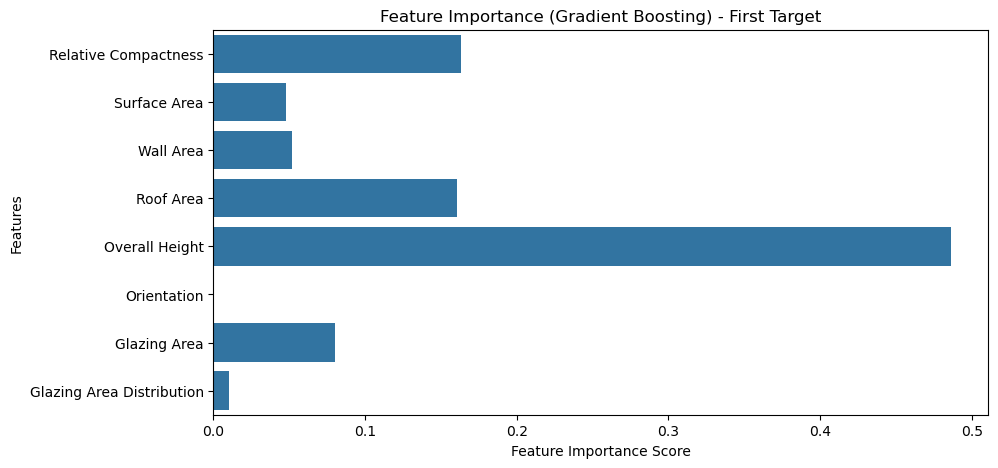

In [14]:
# Check feature importance from the first target's model
feature_importances = best_gbr.estimators_[0].feature_importances_

# Plot feature importances
plt.figure(figsize=(10, 5))
sns.barplot(x=feature_importances, y=X.columns)
plt.title("Feature Importance (Gradient Boosting) - First Target")
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.show()


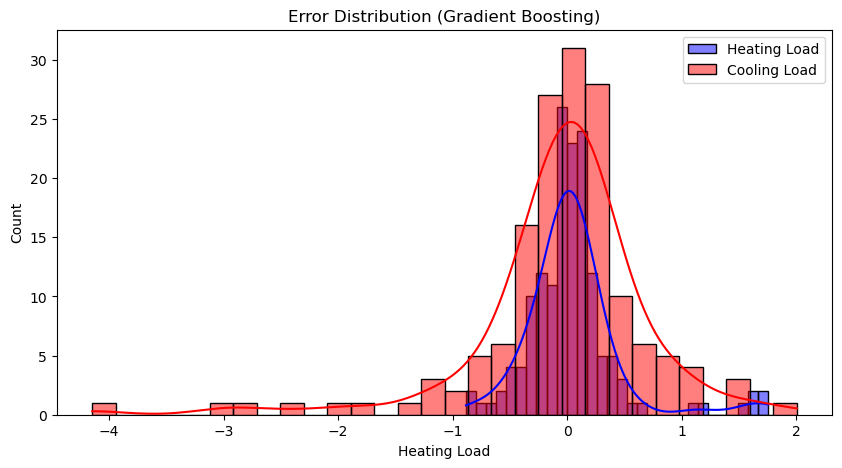

In [15]:
# Error distribution analysis
plt.figure(figsize=(10, 5))
sns.histplot(y_test["Heating Load"] - y_pred_gbr[:, 0], bins=30, kde=True, color='blue', label="Heating Load")
sns.histplot(y_test["Cooling Load"] - y_pred_gbr[:, 1], bins=30, kde=True, color='red', label="Cooling Load")
plt.title("Error Distribution (Gradient Boosting)")
plt.legend()
plt.show()